# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Ограничения:
- random_state = 250722
- метрика качества: AUC-ROC

## Содержание

* [Загрузка данных](#import)
* [Предобработка и Разведочный анализ](#eda)
* [Исследование зависимостей и Feature engineering](#research)
  * [Ежемесячные платежи](#monthly_charges)
  * [Дата подключений](#begin_data)
 * [Взаимосвязи](#relation)
  * [Связь с оттоком](#user_profil1)
  * [Связь с годом подключения](#user_profil2)
* [Построение моделей для прогнозирования оттока](#ml)
 * [Кодирование признаков](#encoding)
 * [Разделение выборок](#split)
 * [Нормализация данных](#normalize)
 * [Модели машинного обучения](#modeling)
 * [CatBoost](#catboost)
* [Анализ модели](#analiz)
 * [Feature importance](#feature_importance)
 * [Качество прогнозов](#prognoz)
* [Вывод](#finish)

# Загрузка данных
<a class="anchor" id="import"></a>

In [12]:
!pip install plotly
!pip install -U kaleido
!pip install skimpy  
!pip install optuna -U
!pip install catboost
# библиотеа для визуализации
!pip install ipywidgets
#jupyter nbextension enable --py widgetsnbextension
!pip install shap

  Using cached plotly-5.9.0-py2.py3-none-any.whl (15.2 MB)
  Using cached numpy-1.23.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.23.1 which is incompatible.
  Using cached numpy-1.21.6-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
      Successfully uninstalled numpy-1.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
skimpy 0.

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = "png" 

# библиотека для предоставления сводной статистики
from skimpy import clean_columns  # для преименования колонок

# библиотеки для машинного обучения

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from catboost import cv
from catboost.utils import get_roc_curve
from catboost import *


# библиотеки для оценки модели
from sklearn.metrics import auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


# библиотека для подбора гиперпараметров модели
import optuna

import shap

from datetime import datetime

In [19]:
# используем конструкцию try-except на случай если не получится работать над проектам локально
try:
    path = '/datasets/final_provider/'
    contract = pd.read_csv(path + 'contract.csv')
    personal = pd.read_csv(path + 'personal.csv')
    internet = pd.read_csv(path + 'internet.csv')
    phone =    pd.read_csv(path + 'phone.csv')
except:
    # для работы в Colab и загрузкой с google drive
    from google.colab import drive
    drive.mount("/content/gdrive")
    path = '/content/gdrive/My Drive/DS/datasets/final_provider/'
    contract = pd.read_csv(path + 'contract.csv')
    personal = pd.read_csv(path + 'personal.csv')
    internet = pd.read_csv(path + 'internet.csv')
    phone =    pd.read_csv(path + 'phone.csv')
    

In [20]:
dfs = [contract, personal, internet, phone]

In [21]:
for item in dfs:

    item.info()
    display(item.head())
    print('==============================================\n')
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Данные загрузили, читаются нормально, с ними можно рабодать. всего абонентов -7043



В каждой таблице присутсвует поле с ID абонента - счтитаю что можно этим воспользоваться для объединения таблиц в одну, это всё равно придется сделать, и так я возможно смогу сразу видеть взаимозвязи в данных.

In [22]:
df = contract.merge(personal, on='customerID', how='left').merge(internet, on='customerID', how='left').merge( phone, on='customerID', how='left')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [24]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


приведем наименование колонок в более читабельный вид

In [25]:
# сперва сделал на логических выражениях , но после узнал что есть спец функция в одной из библиотек
df = clean_columns(df, case = 'snake')

19 column names have been cleaned

In [26]:
df.columns
# так мне будет комфортнее

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

Соединилось всё удачно, всего записей 7043 никого не потеряли. Колонок суммарно получилось -20. в некоторых появились пропуски.<br>
  Теперь исследуем каждый столбец подробней.

# Предобработка и Разведочный анализ
<a class="anchor" id="eda"></a>

customerID 
- айди абонентов в принципе информации в себе не несут - далее нам не потребуются.

In [27]:
df = df.drop('customer_id', axis=1)

### begin_date - дата начала предоставления услуг абоненту

на данный момент в этом сстолбце тип строковый - преобразуем его в datetime

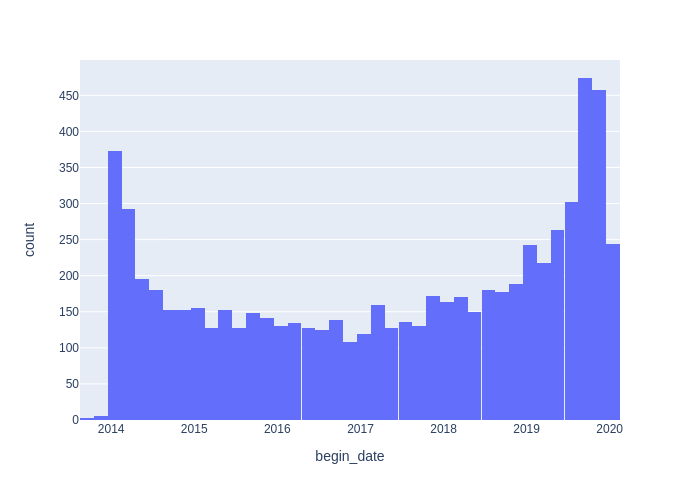

In [28]:
df['begin_date'] = pd.to_datetime(df['begin_date'])
# сразу посмотрим на распредление дат по времени
px.histogram(df, x="begin_date") 

Видим что в конце 2013 года заключались не многочисленные договора, но в январе  2014 было реальное начало подключений, затем количество пдключений в меяц постепенно сокращалось до декабра 2016 и затем начало расти, и в сентябре 2019 снова пик - возможно это связано с проводимыми акциями или заходом оператора в новый район. 

### end_date - дата расторжения договора с абонентом

In [29]:
df['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

также тут данные в текстовом формате , а также присутсвует значение No - что означает что прекращения небыло - заменим его последней датой на момент выгрузки базы данных.( Информация о договорах актуальна на 1 февраля 2020.)

In [30]:
df['end_date'] = df['end_date'].str.replace('No','2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'])


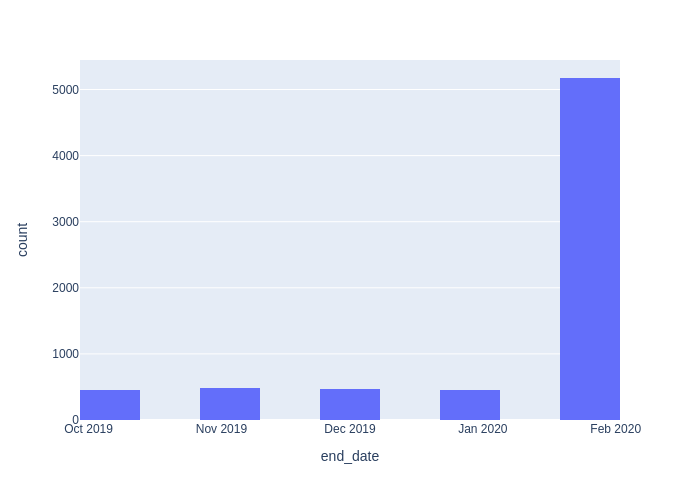

In [31]:
# сразу посмотрим на распредление дат по времени
px.histogram(df, x="end_date",nbins=10)

расторжения начались всего за 4 месяца до даты актуальности данных - и они равномерны. Очень мало информации тут можно подчерпнуть - сезонности не увидеть..

В начале 2020 года тоже были подключения, но информации о том отключился ли кто то из них в следующем месяце - нет, считаю что этих абонентов нужно зачистить из таблицы, потому что однозначно классифицировать их пока рано.

In [32]:
df = df[df['begin_date']<'2020']

### type - тип платежа: ежемесячный или ежегодный
клиенты могут платить каждый месяц или заключить договор на 1–2 года

In [33]:
df['type'].value_counts(normalize=True)

Month-to-month    0.536991
Two year          0.247536
One year          0.215473
Name: type, dtype: float64

Чуть больше половины абоненов используют ежемесячную оплату. 

### paperless_billing - пользуется ли клиент безбумажным биллингом

In [34]:
df['paperless_billing'].value_counts()

Yes    4074
No     2725
Name: paperless_billing, dtype: int64

Большинство используют безбумажный биллинг

### payment_method - метод оплаты  

In [35]:
df['payment_method'].value_counts()

Electronic check             2296
Bank transfer (automatic)    1525
Credit card (automatic)      1502
Mailed check                 1476
Name: payment_method, dtype: int64

### monthly_charges - текущий месячный размер оплаты
<a class="anchor" id="monthly_charges"></a>

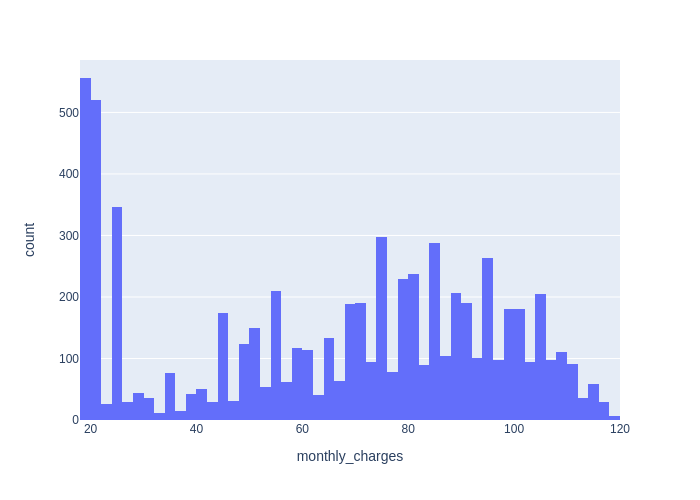

In [36]:
px.histogram(df, x="monthly_charges") 

Видимо фиксированных тарифов нет - сумма оплаты зависит от количества потребленных услуг(трафика). Многие оплачивают минимальные суммы до 26 у.е.<br>


### total_charges 
общая сумма, которую клиент заплатил за услуги за все время

In [37]:
df[df['total_charges'] == ' '].head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines


Обнаружил несколько абонентов с незаполненной графой  total_charges - все они с датой заключения контракта в крайни день, видимо по этому статистика по суммарным платежам у них не заполнена. Заменю пустые значения их жемесячным платежом.

In [38]:
df.loc[df['total_charges'] == ' ','total_charges'] = df.loc[df['total_charges'] == ' ','monthly_charges'].astype(str)

In [39]:
# оцифруем суммы 
df['total_charges'] = df['total_charges'].astype(float)

Часотное распределение сумм вытянулось до максимального значения в районе 8800 уе. Отказники присутствуют практически по всему распрелеоению равномерно, но на минимальных суммах их много больше - скорее это свзано с тем что абонент не долго пользовался услугой и отказался. 

Перейду сразу к столбцам с пропусками:  online_security, online_backup, device_protection,
tech_support,
streaming_tv,
streaming_movies<br>
все они связаны с доп услугами и появились у абонентов при слиянии таблиц - заменю пропуски словом 'No' как указание на отсутсвие данной услуги.

In [40]:
df[['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']] = df[['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']].fillna('No')

In [41]:
# заменим пропуски на категорию - No service
df['multiple_lines'] = df['multiple_lines'].fillna('No service')
df['internet_service']= df['internet_service'].fillna('No service')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6799 entries, 1 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         6799 non-null   datetime64[ns]
 1   end_date           6799 non-null   datetime64[ns]
 2   type               6799 non-null   object        
 3   paperless_billing  6799 non-null   object        
 4   payment_method     6799 non-null   object        
 5   monthly_charges    6799 non-null   float64       
 6   total_charges      6799 non-null   float64       
 7   gender             6799 non-null   object        
 8   senior_citizen     6799 non-null   int64         
 9   partner            6799 non-null   object        
 10  dependents         6799 non-null   object        
 11  internet_service   6799 non-null   object        
 12  online_security    6799 non-null   object        
 13  online_backup      6799 non-null   object        
 14  device_p

Вывод:
В результате процесса предобработки данных все записи сохранены, пропуски заполнены. Аномалий не обнаружено.

# Исследование зависимостей и Feature engineering
<a class="anchor" id="research"></a>

### Ежемесячные платежи
<a class="anchor" id="monthly_charges"></a>

Посмотрим распределения величин ежемесячных платежей  по группам текущих и ушедших абонентов, но сначала создадим столбец с иденификацией ушёл абонент или нет

In [43]:
date = pd.to_datetime('2020-02-01')

df['abonent'] = df['end_date'].apply(lambda x: 'Yes' if x == date  else 'No')
df['abonent'].value_counts(normalize=True)

Yes    0.725107
No     0.274893
Name: abonent, dtype: float64

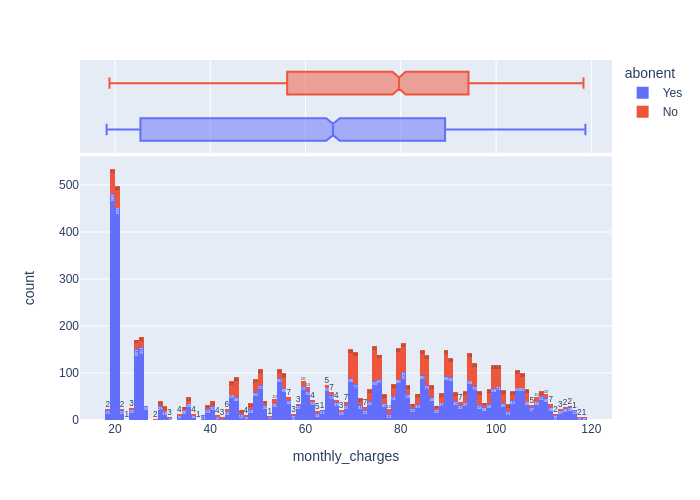

In [44]:
fig = px.histogram(df, x="monthly_charges", 
             color= df['abonent'] ,
             marginal="box" ,
             text_auto=True, 
             nbins=120)
             #labels={'True': 'Not Churn', 'False':'Churn'} 
fig

видим что практически у каждой суммы платежа есть обе группы абонентов,  но видно что на минимальных суммах доля отказавшихся меньше. Заметно что суммы концентрируются около цифр кратных 5
<br><br>
Для каждой группы посчитаем статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. 


In [45]:
# посмотрим на описательную статистику
def pctl25(g):
    return np.percentile(g, 25)

def pctl75(g):
    return np.percentile(g, 75)

pd.pivot_table(df, values='monthly_charges', index= 'abonent', aggfunc=['count', 'mean', 'min', 'max', 'median', pctl25, pctl75])

,count,mean,min,max,median,pctl25,pctl75
,monthly_charges,monthly_charges,monthly_charges,monthly_charges,monthly_charges,monthly_charges,monthly_charges
abonent,,,,,,,
No,1869,74.441332,18.85,118.35,79.650,56.15,94.2
Yes,4930,62.413256,18.25,118.75,65.775,25.35,89.3


Средняя и медианнная сумма платежей у утекших абонентов выше, хотя минимальные и максимальные платежи равны.  Большой разрыв в 25-процентиле - в группе текущих абонентов 25 процентов объектов с суммами до 25уе, но 75-процентилю ситуация почти выровнилась.


Сравним поведение клиентов этих двух групп. Построим графики изображающих:
<br>
- долю пользователей телефонной связи;
- долю интернет-пользователей.

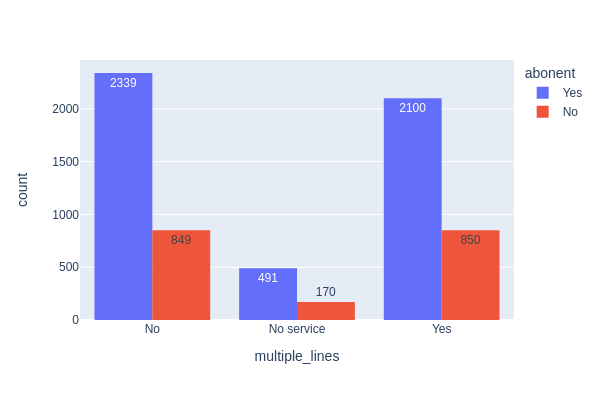

In [46]:
px.histogram(df, x="multiple_lines",
             color='abonent', barmode='group',
             histfunc='count',
             text_auto=True,
             width=600,
             height=400)

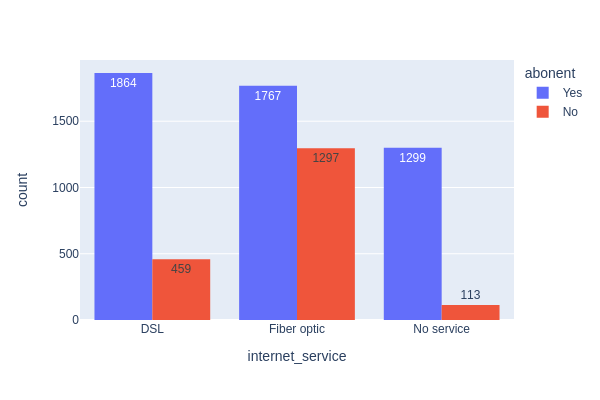

In [47]:
px.histogram(df, x="internet_service", #y="total_bill",
             color='abonent', barmode='group',
             histfunc='count',
             text_auto=True,
             width=600,
             height=400)

Из графиков видно, что признак наличия оптического подключения имеет линейную связь с оттоком, тогда как на отток не влияет - многоли у абонента телефонных линий. Также видим что количество абонентов без интернета больше чем без телефонии.


Добавим новый признак - количество месяцев использования услуг

In [131]:
df['duration'] = ((df['end_date'] - df['begin_date'])/np.timedelta64(1, 'D')).round()

df['duration'].describe()

count    6799.000000
mean     1020.318870
std       738.198573
min        30.000000
25%       306.000000
50%       944.000000
75%      1706.000000
max      2191.000000
Name: duration, dtype: float64

максимальная продолжительнось - 2191 день, что является 6ю годами, тоесть абонент с 2014 года

### Дата подключений
<a class="anchor" id="begin_data"></a>

Посмотрим - когда подключали отказников

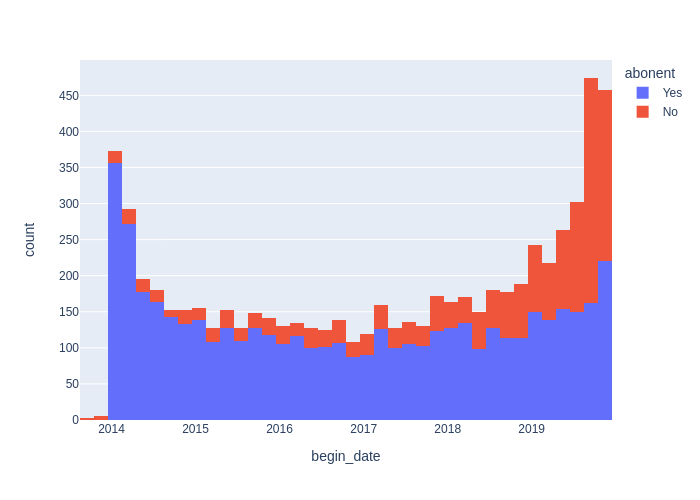

In [49]:
px.histogram(df, x="begin_date",color='abonent') 
#px.histogram(df, x="end_date", color='abonent') 

Получается что отказников много именно из подключенных в последний год - в конце 2019 из подключенных абонентов половина отключилась. Видно что резкий качет на подключениях абонентов негативно сказывается на удержании. 

Посмотрим на сколько абонентов удается подключить и удержать от года к году 

In [50]:
df['begin_year'] = df["begin_date"].dt.year

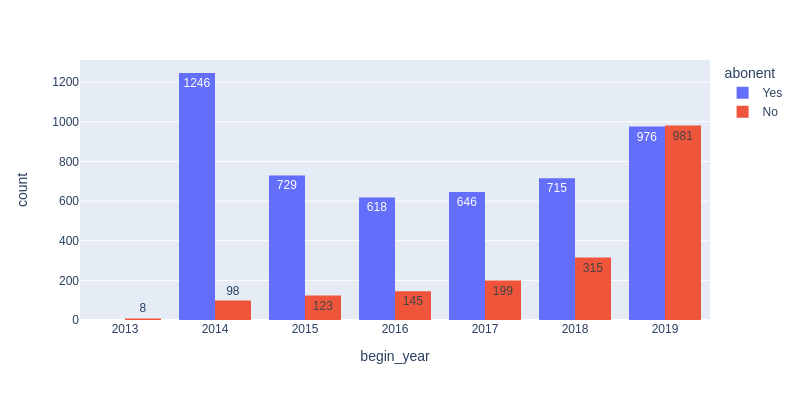

In [51]:
px.histogram(df, x="begin_year",
             color='abonent',
             barmode='group',
             histfunc='count',
             text_auto=True,
             width=800,
             height=400
            )

Данный признак как  цифра года пподключения не может влиять на решение абонента: оставаться или нет, это только косвенно говорит о том что в компании в 2019 году начались какие то изменения приводящие к оттоку клиентов.

In [52]:
df = df.drop('begin_year', axis=1)

## Взаимосвязи
<a class="anchor" id="relation"></a>

Посмотрим на матрицу корреляции числовых признаков(не обращаем внимания senior_citizen - этот признак бинарно кодированный)

In [53]:
df.corr()

,monthly_charges,total_charges,senior_citizen,duration
monthly_charges,1.000000,0.645242,0.213348,0.218328
total_charges,0.645242,1.000000,0.094457,0.819185
senior_citizen,0.213348,0.094457,1.000000,0.002527
duration,0.218328,0.819185,0.002527,1.000000


Ввижу высокую корреляцию межджу общей суммой платежей и количеством месяцев использования услуги - логично, ео придется один из этих признаков удалить из-за мультиколлинеарности.
Еще есть средняя корреляция между общей суммой платежей и ежемесячной платой.

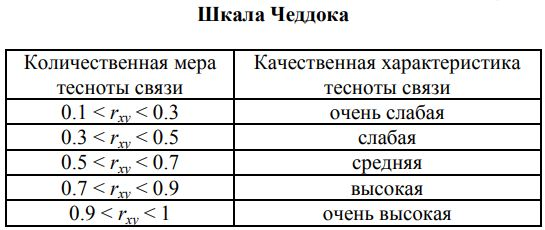

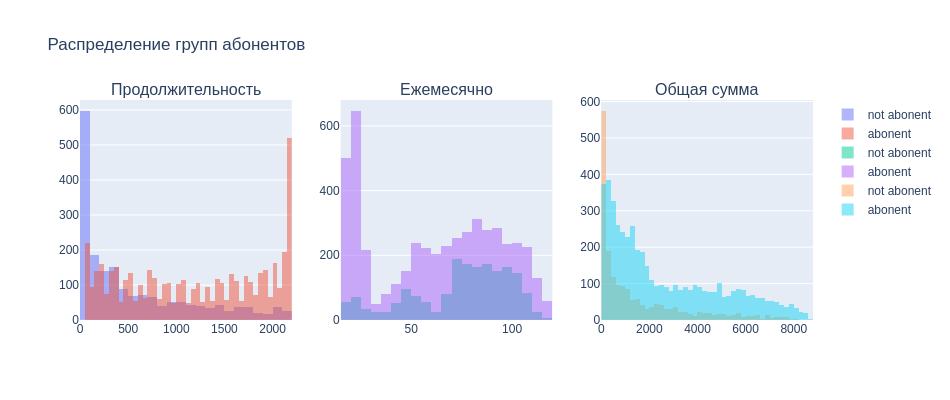

In [54]:
x0 = df[df['abonent'] == 'No']['duration']
x1 = df[df['abonent'] == 'Yes']['duration']
x2 = df[df['abonent'] == 'No']['monthly_charges']
x3 = df[df['abonent'] == 'Yes']['monthly_charges']
x4 = df[df['abonent'] == 'No']['total_charges']
x5 = df[df['abonent'] == 'Yes']['total_charges']

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Продолжительность", 
                                    "Ежемесячно", 
                                    "Общая сумма"))

fig.add_trace(go.Histogram(x=x0, name='not abonent'),
              row=1, col=1)
fig.add_trace(go.Histogram(x=x1, name='abonent'),
              row=1, col=1)

fig.add_trace(go.Histogram(x=x2, name='not abonent'),
              row=1, col=2)
fig.add_trace(go.Histogram(x=x3, name='abonent'),
              row=1, col=2)

fig.add_trace(go.Histogram(x=x4, name='not abonent'),
              row=1, col=3)
fig.add_trace(go.Histogram(x=x5, name='abonent'),
              row=1, col=3)

fig.update_layout(barmode='overlay',
                  title_text="Распределение групп абонентов",
             width=950,
             height=400
             )
fig.update_traces(opacity=0.5)
fig.show('png')

На графике "Продолжительность"видно что чем больше месяцев клиент поьзуется услугами тем меньше вероятность оттока этого клиента. 
На графике "Ежемесячно " видно что чем меньше платеж тем меньше вероятности оттока абонента


### Связь с оттоком
<a class="anchor" id="user_profil1"></a>

Посмотрим связь категориальных и бинарных признаков с оттоком клиентов.

In [55]:
# Определение списка категориальных признаков, за исключением целевого признака
col_lst =['senior_citizen'] + df.columns[df.dtypes == object][:-1].to_list()
col_lst

['senior_citizen',
 'type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

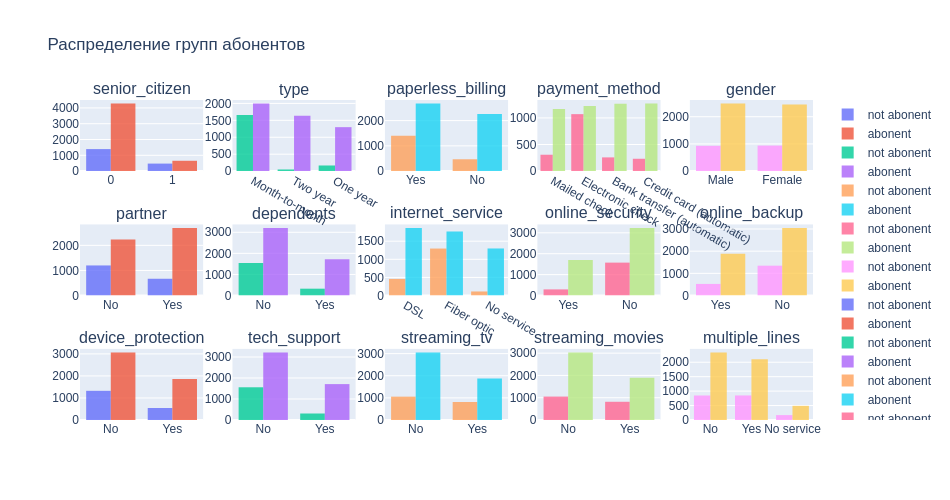

In [58]:
fig = make_subplots(rows=3, cols=5,
                    subplot_titles=col_lst)

no_yes = ['No', 'Yes']
not_abonent = ['not abonent', 'abonent']

# немного автоматизируем создание графиков
for i in range(15):
    for j in range(2):
        fig.add_trace(go.Histogram(
            x= df[df['abonent'] == no_yes[j % 2]][col_lst[i]],
            name=not_abonent[j % 2]  
                                  ),
            row=( i // 5 + 1 ), 
            col = max(i % 5 + 1 , 1)    
                     )
    
fig.update_layout(barmode='group',
                  title_text="Распределение групп абонентов",
             width=950,
             height=500
             )
fig.update_traces(opacity=0.8)
fig.show('png')

Многие признаки имеют линейную взяимосвязь с целевым признаком, но доля отказников в признаках gender, phone_service, multiple_lines, streaming_tv и streaming_movies почти ровна с долей оставшихся - тоесть взаимосвязи на первый вззгляд нет.



### Связь с годом подключения
<a class="anchor" id="user_profil2"></a>

In [59]:
date = pd.to_datetime('2019-01-01')

df['begin_in_2019'] = df['begin_date'].apply(lambda x: 'Yes' if x >= date  else 'No')
df['begin_in_2019'].value_counts(normalize=True)

No     0.712164
Yes    0.287836
Name: begin_in_2019, dtype: float64

In [60]:
# Определение списка категориальных признаков, за исключением целевого признака
col_lst =['senior_citizen'] + df.columns[df.dtypes == object][:-2].to_list()


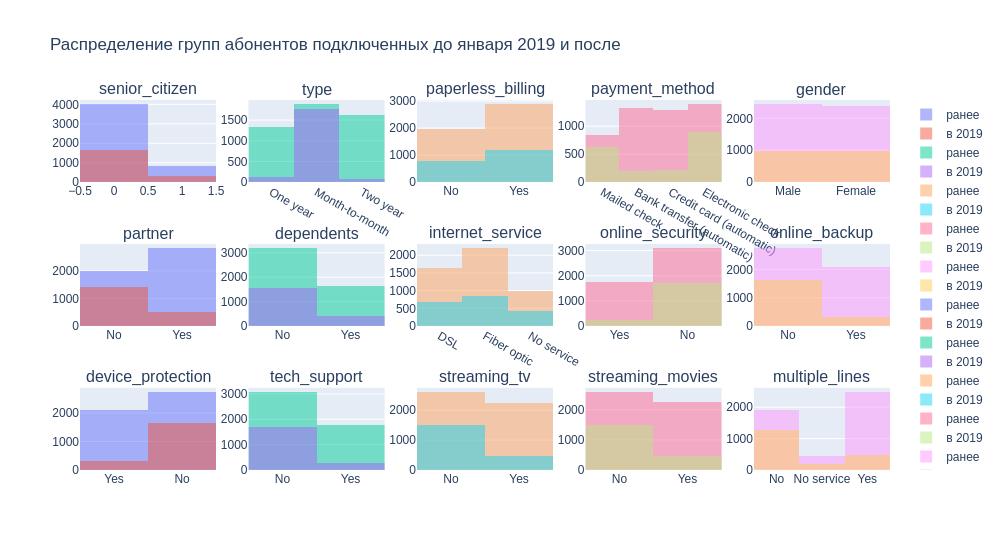

In [63]:
fig = make_subplots(rows=3, cols=5,
                    subplot_titles=col_lst)
no_yes = ['No', 'Yes']
not_abonent = ['not abon', 'abonent']
beg_in_2019 = ['ранее','в 2019']

# немного автоматизируем создание графиков
for i in range(15):
    for j in range(2):
        fig.add_trace(go.Histogram(
            x= df[df['begin_in_2019'] == no_yes[j % 2]][col_lst[i]],
            name=beg_in_2019[j % 2] ,  
            ),
            row=( i // 5 + 1 ), 
            col = max(i % 5 + 1 , 1)    
                     )
    
fig.update_layout(barmode='overlay', #'relative', #'group',
                  title_text="Распределение групп абонентов подключенных до января 2019 и после",
             width=1000,
             height=550
             )
fig.update_traces(opacity=0.5)
fig.show('png')

На графиках видим что типичные портреты абонентов, подключенных до января 2019 и после, различаются во многих признаках:
- тип платежей - подключенные до 2019 года в 10 раз чаще заключали годовой контракт
- автоматический тип оплаты в 2018 году во много сократился
- в 2019 году подключалось больше без партнеров
- в 2019 году абсолютное большинство подключаемых отказывались от доп услуг, мало кто подключат дополнительные телефонные линии

In [64]:
period = df['begin_date'].dt.to_period("Y")
pd.pivot_table(df, index=period ,columns='abonent', values='monthly_charges', aggfunc='mean')

abonent,No,Yes
begin_date,,
2013,100.531250,NaN
2014,96.164796,74.558266
2015,88.471138,67.974760
2016,84.333448,62.697006
2017,83.348492,61.193266
2018,78.790635,54.638531
2019,65.633792,49.077869


Различия есть также и среднемесячных платежах

В процессе иследования я уже создал дополнительные признаки abonent и duration, 
есть идея - создать признак который будет отражать увеличение или уменьшение среднемесячных платежей, то есть отношение ежемесячного платежа к сумме платежей всего, разделенная на количество месяцев.  

In [65]:
df['avr_month_more'] = ((df['total_charges'] / (df['duration']/30)) > df['monthly_charges']).astype(int)

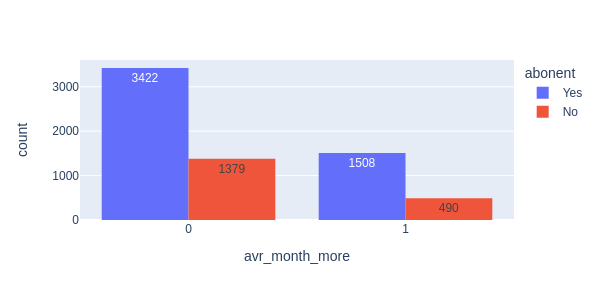

In [66]:
px.histogram(df, x="avr_month_more",
             color='abonent', barmode='group',
             histfunc='count',
             text_auto=True,
             width=600,
             height=300)

In [67]:
df['avr_month_more'].corr(df['abonent'].replace(to_replace=['No', 'Yes'], value=[0, 1]))

0.0428396585311461

Корреляции почти нет

### Вывод
Во время проведения анализа были созданы новые и определены признаки которые могу оказывать сильное влияние на отток клиентов, используем их для прогнозирования целевой переменной и оценим это влияние.<br><br>
Но мне кажется что данных которые бы явно указывали на решение абонента в скорем времени утеч тут нет: например обращения в тех поддерку,  глобальных аварий, качество (скорость и объем) загрузки трафика абонентом среднее за месяц, место проживание (город, село), количество аварий на сети в районе абонента, тарифный план ...

# Построение моделей для прогнозирования оттока
<a class="anchor" id="ml"></a>


## Кодирование признаков 
<a class="anchor" id="encoding"></a>

перед тем как передавать данные в модель переведем их в нормальный для нее вид

In [68]:
# получим имена колокнок с типом данных j,ject
col_lst =['senior_citizen'] + df.columns[df.dtypes == object].to_list()

In [69]:
for i in col_lst:
    if len(df[i].value_counts()) == 2:  # там где два вида значений (предполагаю No и Yes) 
        df[i].replace(to_replace=['No', 'Yes'], value=[0, 1], inplace=True) # меняю на 0 и 1

In [70]:
# колонки которые не содержат 'No', 'Yes'.
col_lst = df.columns[df.dtypes == object].to_list()
col_lst

['type', 'payment_method', 'gender', 'internet_service', 'multiple_lines']

Преобразуем категориальные переменные этих признаков  в фиктивные/индикаторные переменные

In [71]:
# преобразование признаков
features_df = pd.get_dummies(df, columns=df.columns[df.dtypes==object], drop_first=True)

features_df.head()


,begin_date,end_date,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,...,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,internet_service_Fiber optic,internet_service_No service,multiple_lines_No service,multiple_lines_Yes
1,2017-04-01,2020-02-01,0,56.95,1889.50,0,0,0,1,0,...,1,0,0,0,1,1,0,0,0,0
2,2019-10-01,2019-12-01,1,53.85,108.15,0,0,0,1,1,...,0,0,0,0,1,1,0,0,0,0
3,2016-05-01,2020-02-01,0,42.30,1840.75,0,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
4,2019-09-01,2019-11-01,1,70.70,151.65,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
5,2019-03-01,2019-11-01,1,99.65,820.50,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


Количество признаков увелчилось из за способа их кодирования. теперь мы готовы пристуить к дальнейшим действиям.

## Разделение выборок
<a class="anchor" id="split"></a>

In [72]:
random_state = 250722
np.random.seed(random_state)

In [73]:
X = features_df.drop(['abonent','begin_date','end_date','total_charges','begin_in_2019'], axis=1)
y = features_df['abonent']
X.shape, y.shape

((6799, 23), (6799,))

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=250722, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5439, 23), (1360, 23), (5439,), (1360,))

## Нормализация данных
<a class="anchor" id="normalize"></a>

Приведём различные данные к единому виду, подходящему для всех алгоритмов машинного обучения.

In [148]:
# Нормализация значений признаков
mms = MinMaxScaler()
X_train_trans = mms.fit_transform(X_train[['monthly_charges','duration']])
X_test_trans = mms.transform(X_test[['monthly_charges','duration']])

In [150]:
X_train = pd.concat([
                     pd.DataFrame(X_train_trans, columns=['monthly_charges','duration']).set_index(X_train.index),
                     X_train.drop(['monthly_charges','duration'],axis=1), 
                     ],
                     axis=1)
X_test = pd.concat([
                    pd.DataFrame(X_test_trans, columns=['monthly_charges','duration']).set_index(X_test.index),
                    X_test.drop(['monthly_charges','duration'],axis=1), 
                    ],
                    axis=1)

In [151]:
X_train.head()

,monthly_charges,duration,paperless_billing,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,internet_service_Fiber optic,internet_service_No service,multiple_lines_No service,multiple_lines_Yes
6196,0.913433,0.958815,1,0,0,0,1,1,1,0,...,0,1,1,0,0,1,1,0,0,1
2297,0.916418,0.747339,0,0,1,0,0,1,1,1,...,1,0,0,1,0,0,1,0,0,1
3114,0.566169,0.056918,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
6679,0.193532,0.831097,0,0,1,0,1,1,0,1,...,0,1,0,0,0,0,0,0,1,0
3496,0.557711,0.338269,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0


## Модели машинного обучения
<a class="anchor" id="modeling"></a>


In [152]:
y_train.shape, X_train.shape

((5439,), (5439, 23))

In [153]:
# Определение базовых алгоритмов машинного обучения
models = [KNeighborsClassifier(), 
          GaussianNB(), 
          SVC(random_state=random_state), 
          RandomForestClassifier(n_jobs=-1, random_state=random_state), 
          CatBoostClassifier(random_seed=random_state),
          ]
          
# Список метрик качества алгоритмов
scores = []

# Поиск подходящего базового алгоритма машинного обучения
for n, model in enumerate(models):
    scores.append(cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1).mean())

# Список наименований базовых алгоритмов
names = ['Метод К-ближайших соседей', 'Байесовский классификатор', 
         'Метод опорных векторов', 'Случайный лес', 'Градиентный бустинг']

# Вывод метрик качества базовых алгоритмов
pd.DataFrame({'AUC': scores}, index=names)

Learning rate set to 0.020298
0:	learn: 0.6763315	total: 48.9ms	remaining: 48.9s
1:	learn: 0.6621725	total: 51ms	remaining: 25.4s
2:	learn: 0.6451779	total: 53ms	remaining: 17.6s
3:	learn: 0.6323091	total: 54.9ms	remaining: 13.7s
4:	learn: 0.6181797	total: 57ms	remaining: 11.3s
5:	learn: 0.6053124	total: 60.2ms	remaining: 9.97s
6:	learn: 0.5923552	total: 63.2ms	remaining: 8.97s
7:	learn: 0.5817404	total: 66.6ms	remaining: 8.26s
8:	learn: 0.5712282	total: 69.7ms	remaining: 7.67s
9:	learn: 0.5643458	total: 71.1ms	remaining: 7.03s
10:	learn: 0.5536020	total: 74.4ms	remaining: 6.69s
11:	learn: 0.5462416	total: 77.7ms	remaining: 6.4s
12:	learn: 0.5370216	total: 81ms	remaining: 6.15s
13:	learn: 0.5285961	total: 84.8ms	remaining: 5.97s
14:	learn: 0.5225711	total: 88.3ms	remaining: 5.8s
15:	learn: 0.5149202	total: 91.6ms	remaining: 5.63s
16:	learn: 0.5088637	total: 94.8ms	remaining: 5.48s
17:	learn: 0.5023844	total: 98.1ms	remaining: 5.35s
18:	learn: 0.4958183	total: 101ms	remaining: 5.23s
19:

,AUC
Метод К-ближайших соседей,0.799851
Байесовский классификатор,0.834494
Метод опорных векторов,0.831717
Случайный лес,0.864446
Градиентный бустинг,0.921745


Из полученных результатов видно, что лучший результат показал Градиентный бустинг.

Перейдем к его оптимизации под задачу прогнозирования оттока клиентов. 

Настройку гиперпараметров модели реализуем через случайный поиск с оценкой по метрике AUC.

## CatBoost
<a class="anchor" id="catboost"></a>

в библиотеке CatBoost реализрован агоритм автоматического кодирования категориальных признаков - воспользуемся им.

In [154]:
# Подготовим данные для CatBoost
X_cat = df.drop(['abonent','begin_date','end_date','total_charges','begin_in_2019'], axis=1)
y_cat = df['abonent']
# индексы категореальных признаков
cat_features = [0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,17]

In [155]:
# создадим пул данных для модели
pool = Pool(data=X_cat,label=y_cat, cat_features=cat_features)

In [156]:
# разобъём выборки на тренировочные и тестовые
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat,y_cat,test_size=0.2, random_state=250722, stratify=y)
X_cat_train.shape, X_cat_test.shape, y_cat_train.shape, y_cat_test.shape

((5439, 18), (1360, 18), (5439,), (1360,))

In [157]:
def objective(trial, data=X, target=y):
    X_train, X_val, y_train, y_val = train_test_split(X_cat, y_cat, test_size=0.2) #, random_state=random_state)

    params = {
        'iterations': trial.suggest_int('iterations', 500, 2100, 200),
        #'max_depth': trial.suggest_int('max_depth', 3, 63, 3),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.08, 0.1, 0.115, 0.15]),
        #'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
        #'max_bin': trial.suggest_int('max_bin', 200, 400),
        #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        'subsample': trial.suggest_float('subsample', 0.3, 0.8),
        'random_seed': random_state,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'boosting_type':'Ordered',
        'bootstrap_type':'Bernoulli'    
    }
    
    model = CatBoostClassifier(**params, cat_features=cat_features)  
    model.fit(X_train, y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 222, verbose = False)
    y_pred = model.predict_proba(X_val)[:,1]
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc

start = datetime.now()
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 30)
print('time: ',datetime.now() - start)

print(study.best_params)
print('Best value:', study.best_value)

[I 2022-08-02 19:38:29,388] A new study created in memory with name: no-name-0fdb0cf5-83ed-4251-8428-b16efb328837
[I 2022-08-02 19:39:03,824] Trial 0 finished with value: 0.9474412799880274 and parameters: {'iterations': 1900, 'learning_rate': 0.08, 'subsample': 0.7391467513562813}. Best is trial 0 with value: 0.9474412799880274.
[I 2022-08-02 19:39:19,884] Trial 1 finished with value: 0.9338558375634518 and parameters: {'iterations': 900, 'learning_rate': 0.15, 'subsample': 0.5477001237489463}. Best is trial 0 with value: 0.9474412799880274.
[I 2022-08-02 19:39:34,308] Trial 2 finished with value: 0.9381190752306071 and parameters: {'iterations': 900, 'learning_rate': 0.15, 'subsample': 0.5657997244893159}. Best is trial 0 with value: 0.9474412799880274.
[I 2022-08-02 19:39:57,617] Trial 3 finished with value: 0.9312465086479632 and parameters: {'iterations': 2100, 'learning_rate': 0.1, 'subsample': 0.4514774632044827}. Best is trial 0 with value: 0.9474412799880274.
[I 2022-08-02 19:

time:  0:10:13.678415
{'iterations': 900, 'learning_rate': 0.08, 'subsample': 0.580933316240242}
Best value: 0.9552764191492515


In [158]:
# теперь обучим модель на подобранных гиперпараметрах 
model_cbc = CatBoostClassifier(**study.best_params,
                               #iterations = 700,
                               #learning_rate = 0.115,
                               loss_function='Logloss',
                               custom_loss=['AUC', 'Accuracy'],
                               objective='Logloss',
                               eval_metric = 'AUC',
                               #boosting_type='Ordered',
                               #bootstrap_type='Bernoulli',
                               #subsample=0.5,
                               cat_features=cat_features,
                               random_seed=random_state,
                               verbose=100)
model_cbc.fit(X_cat_train, 
              y_cat_train,
              cat_features=cat_features,
              #eval_set=(X_cat_test, y_cat_test)
              )

0:	total: 16ms	remaining: 14.4s
100:	total: 794ms	remaining: 6.28s
200:	total: 1.51s	remaining: 5.26s
300:	total: 2.25s	remaining: 4.48s
400:	total: 3.16s	remaining: 3.94s
500:	total: 4.11s	remaining: 3.27s
600:	total: 4.92s	remaining: 2.45s
700:	total: 5.73s	remaining: 1.63s
800:	total: 6.59s	remaining: 814ms
899:	total: 7.39s	remaining: 0us


In [160]:
# получим предсказания одного из классов
pred_prob = model_cbc.predict_proba(X_cat_test)[:,1]
# подсчитаем требуемую метрику на тесте
roc_auc_score(y_cat_test, pred_prob)

0.9426353982492868

In [166]:
# можно сравнить с расчетами полученными с помощью утилиты из catboost
eval_pool = Pool(X_cat_test, y_cat_test, cat_features=cat_features)
(fpr, tpr, thresholds) = get_roc_curve(model_cbc, eval_pool)
auc(fpr,tpr)

0.9426353982492869

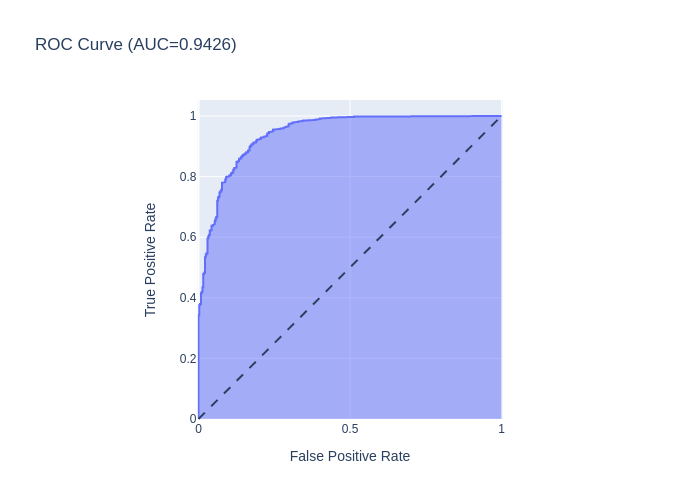

In [167]:
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

ROC AUC хороший

# Анализ модели
<a class="anchor" id="analiz"></a>

## Feature importance
<a class="anchor" id="feature_importance"></a>

Для того что бы понять что влияет на отток посмотрим на важность признаков при классификации абонента

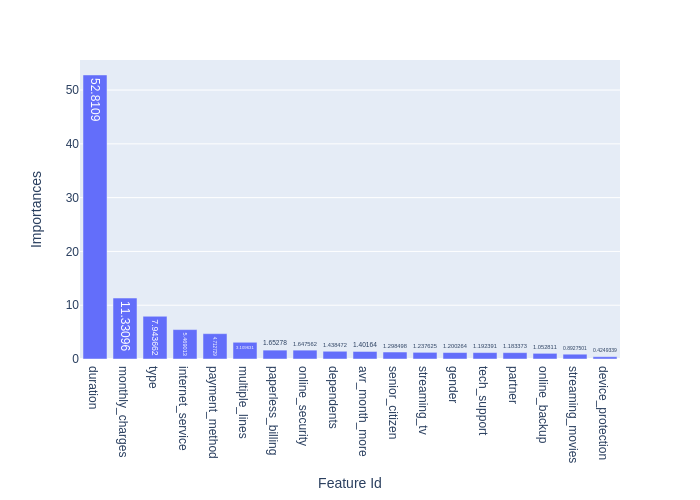

In [168]:
feat_imp = model_cbc.get_feature_importance(prettified=True)
px.bar(feat_imp, x='Feature Id',y='Importances', text_auto=True)

Самым влиятельным признаком является срок жизни абонента - почти 50%. Это обусловлено тем что массовый отток случился в последние месяцы подключений - среди вновь подключенных.

Остальные признаки влияют сильно меньше.

Посмотрим на влияние признаков - воспользуемся встроенными средствами CatBoost  

In [169]:
explainer = shap.TreeExplainer(model_cbc)
shap_values = explainer.shap_values(Pool(X_cat_test, y_cat_test, cat_features=cat_features))

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10,:], X_cat_test.iloc[10,:])

На данном изображении видно, что для пятого объекта фитчи Duration, Type, monthly_charges и т.д., двигают предсказание в отрицательую сторону - увеличиая вероятность присвоить абоненту класс - 0 (отток). 

In [170]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[100,:], X_cat_test.iloc[100,:])

А тут полная противоположная ситуация: абонент давно подключенный к DSL с дополнительными услугами и контрактом на два года - однозначно не отток

График влияния важности признаков сразу на 50 объектах.

можно подробно изучить влияние каждого признака, даже относительно другого

In [171]:
X_small = X_cat_test.iloc[0:50]
shap_small = shap_values[:50]
shap.initjs()
shap.force_plot(explainer.expected_value, shap_small, X_small)

 дданном случае можно видеть как на классификацию влияет значение признака Internet_service: абоненты подключенные к DSL приктически и не думают об отключении. Тогда как абоненты подключеные по оптическому волокну постонно оттекают.

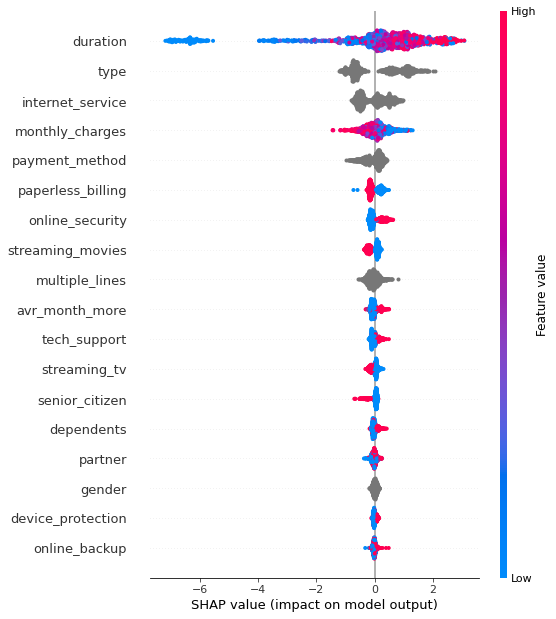

In [172]:
shap.summary_plot(shap_values, X_cat_test)

Еще один тип графиков, на которых удобно интопретировать модель.
Цвет определяет значение признака. чем краснее тем значение выше(серый - это график не переварил несколько пременных в категоиальных признаках). Разположение точки оотносительно черты - указывает на то в какую сторону классификации фитча склоняет объект: правее черты - в положительную... 

И так , что мы видим:
- duration с большим значением сильно влияет классификацию в положительную сторону(не отток)
- monthly_charges наоборот: чем значение фитчи меньше тем положительней классифицируется объект
- внизу графика признаки с наименьшим влиянием: видно как они перемешаны вокруг черты, получается практически не способствуют классификации 

В прочем все это мы уже видели при исследовании данных.

## Качество прогнозов
<a class="anchor" id="prognoz"></a>

Нашей задачей является прогноз оттока абонентов. Но нам важно как найти всех кто хочет уйти, так и не предлогать промокоды и специальные условия всем подряд.


In [173]:
pred = model_cbc.predict(X_cat_test)
pd.DataFrame({'metric' : ['Recall','Precision','F1'], 'score': [ recall_score(y_test, pred), precision_score(y_test, pred), f1_score(y_test, pred)]})

,metric,score
0,Recall,0.957404
1,Precision,0.903349
2,F1,0.929591


Показатели полноты и точности с хорошим результатов выше 0.9, соответсвенно и сбалансированная F-мера тоже.

Посмотрим на матрицу ошибок

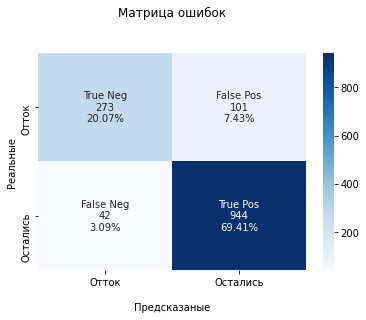

In [174]:
def show_cf_matrix(y, pred):
    cf_matrix = confusion_matrix(y, pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Матрица ошибок\n\n');
    ax.set_xlabel('\nПредсказаные')
    ax.set_ylabel('Реальные');
    ax.xaxis.set_ticklabels(['Отток','Остались'])
    ax.yaxis.set_ticklabels(['Отток','Остались'])
    plt.show()


show_cf_matrix(y_cat_test, pred)

In [175]:
len(y_cat_test), y_cat_test.sum(), len(y_cat_test) - y_cat_test.sum()

(1360, 986, 374)

Как видим на тестовых данных при treshold(пороге присвоения класса) = 0.5 из 1360 абонентов из которых 374 отключенцев не верно индефицированы почти 30 процентов.

Посмотрим на другие пороги
(далее код взятый из сторонних источников для построения интерактивного графика)

In [176]:
def get_tp_pp(y, proba, threshold):
    """Return the number of true positives."""
    # Classify into classes
    pred = np.where(proba>=threshold, 1, 0)
   
    # Count true positives
    true_positives = np.sum((y==1) & (pred==1))
    positive_predictions = np.sum(pred==1)
    return true_positives, positive_predictions

predict_proba = model_cbc.predict_proba(X_cat_test)[:,1]

# Find precision & recall for thresholds
positives = np.sum(y_cat_test==1)
columns = ['threshold', 'precision', 'recall']
inputs = pd.DataFrame(columns=columns, dtype=np.number)
thresholds = np.arange(0, 1, 0.001)
for i, threshold in enumerate(thresholds):
    inputs.loc[i, 'threshold'] = threshold
    true_positives, positive_predictions = get_tp_pp(y_cat_test, predict_proba, threshold)
    inputs.loc[i, 'precision'] = true_positives/positive_predictions
    inputs.loc[i, 'recall'] = true_positives/positives
#inputs

def plot_interactive_precision_recall_curve(df, precision, recall, thresholds):
    fig = px.area(
        data_frame=df, 
        x=recall, 
        y=precision,
        hover_data=thresholds, 
        title='Precision-Recall Curve'
    )
    fig.update_layout(
        autosize=False,
        width=500,
        height=500,
        margin=dict(l=30, r=30, b=30, t=30, pad=4),
        title_x=.5, # Centre title
        hovermode = 'closest',
        xaxis=dict(hoverformat='.4f'),
        yaxis=dict(hoverformat='.4f')
    )
    hovertemplate = 'Recall=%{x}<br>Precision=%{y}<br>Threshold=%{customdata[0]:.4f}<extra></extra>'
    fig.update_traces(hovertemplate=hovertemplate)
    
    # Add dashed line with a slope of 1
    fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
    fig.show()

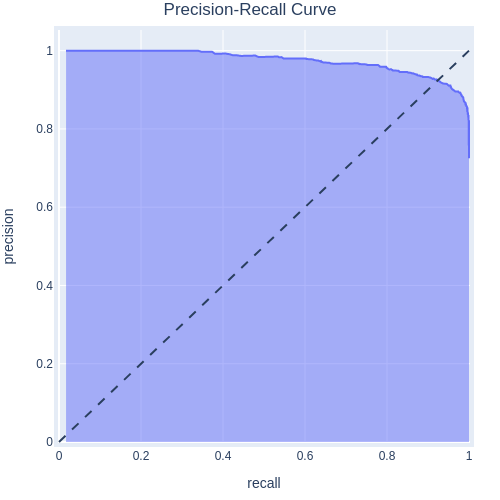

In [177]:
plot_interactive_precision_recall_curve(df=inputs, 
                           precision='precision', 
                           recall='recall', 
                           thresholds=['threshold'])

на этом интерактивном(не в этом случае) графике можно давольно точно обнаружить порог чуствительности который бы устрои отдел маркетинга, порого при котором можно найти интересующий баланс между "найти всех отключенцев" и "не раздовать промокоды всем подряд"

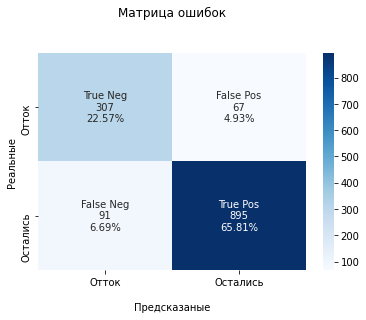

In [178]:
# еще раз получим предсказания но с другим порогом чствительности - 0.65
pred =((model_cbc.predict_proba(X_cat_test)[:,1] > 0.65)*1)

show_cf_matrix(y_cat_test, pred)

Если маргетингу потребуется отловить всех кто подумывает отключиться и за одно обработать тех кто так сказать в зоне риска - можно еще повысить порог чуствительности. Вероятность оттока абонента позволяет оценить не только степень уверенности в его потерю, но и понять с какой группой абонентов следует работать в первую очередь.  

# Вывод:
<a class="anchor" id="finish"></a>

План выполнения задачи<br><br>

- Загрузил и осмотрел данные.<br>
Предоставленные таблицы объединили в одну для простоты обращения с данными, пропусков и аномалий не обнаружено. Записей мало - ввсего 7043, но я решил удалить 244 абонента подключенных в январе 2020, так как их не возможно однозначнно классифицировать как не отток.

- Преобразовал типы столбцов.<br>

- Исследовал данные.<br>
Проанализировав полученные данные составил портрет типичного не утекающего абонента: это пожилой человек, супруг, подключен к DSL, оплачивает дополнительные услуги, контракт на 1 или 2 года.

- Искал взаимосвязи в данных. <br>
В 2019 году начался рост числа подключений, но и все отключения начались также в этом году, абоненты практически перестали заключать долгосрочные контракты(чтобы иметь возможность оперативно отключиться), использовать дополнительные услуги, подключать телефонию.

- Проанализировал найденные взаимосвязи. <br>
Анализ данных указывает на то что отключающиеся чаще всего не пожилые абоненты подключенные к оптическому волокну. Эта технология предоставляет возможность пользоватиься высокоскоростным подключением к интернету, но если транзитное оборудование провайдера современно и справляется с нагрузками, и нет других ограничений. Для того чтобы понять из-за чего происходит массовый отток новых абонентов требуется больше данных: например обращения в тех поддерку, глобальных аварий, качество (скорость и объем) загрузки трафика абонентом среднее за месяц, место проживание (город, село), количество аварий на сети в районе абонента, тарифный план, присутствие сторонних провайдеров ...

- Подготовка данных к моделированию. <br>
Перед тем как стороить модели признаки были закодированны алгоритмом OHE и произведено масштабирование для того чтобы нивелировать влияние дисперсии на работу различных алгоритмов машинного обучения.

- Сравнение и отбор базовых моделей. <br>
Для решения задачи классификации был проведен "конкурс" среди базовых алгоритмов классификации с гиперпараметрами по умолчанию в результате которогго для дальнейшей работы был выбран алгоритм градиентного бустинга из библиотеки Catboost.

= Подбор гиперпараметров выбранной модели. 
После подбора параметров и их валидации алгроитм показал на требуемой метрике AUC значение 0.93.

- Анализ модели. <br>
С помощью полученной модели с подобранной чуствительностью мы можем верно классифицировать около 75 процентов абонентов из планирующих отключиться и на каждые пять таких абонентов будет приходиться один абонент ложноклассифицированный(как отток). Так же с помощью полученных вероятносте предсказаний модели можно опоедилить группу риска - скем нужно работать в первую очередь Если необходимо охватить больший процент оттока то придется закладывать возможность раздавать больше промокодов - что тоже может привести уменьшению прибыли на абонентах которые не планировали отключаться.

Анализ модели подтвердил обнаруженные взаимосвязи и указывает на то что у провайдера проблемы с удержание абонентов подключенных в последнее время по оптоволокону.

Что можно улучшить:

- изучить подробнее плияние признаков, убрать те которые вносят больше шума чем пользы.<br>
- получить больше данных для исследований: больше абонентов и больше признаков для них.<br>
<br>
Рекомендация провайдеру: Собрать обратную связь с абонентов и отключившихя и не отключившихся. Обратить внимание на качество работы оптико-волоконной сети, скорее всего оно деградирует. Возможно в 2019 года начали подключать абонентов в новой для сябе районе - требуется лучше изучить рынок провайдерских услуг на местности - абоненты отключаются и переключаются к конкурентам. Возможно нужно пересмотреть тарифную политику.
